# ex6 : Support Vector Machines

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
from sklearn import svm

## Part 1: Loading and Visualizing Data

In [2]:
def plotData(X, y):
    pos = y.ravel() == 1
    neg = y.ravel() == 0
    plt.plot(X[pos,0], X[pos,1],'k+', ms=7)
    plt.plot(X[neg,0], X[neg,1],'ko', ms=7, mfc='yellow')

X: (51, 2)
y: (51, 1)


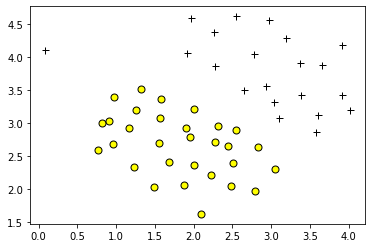

In [3]:
data = loadmat('ex6/ex6data1.mat')
X = data['X']
y = data['y']
print('X:', X.shape)
print('y:', y.shape)

plotData(X, y)
plt.show()

## Part 2: Training Linear SVM

In [4]:
def visualizeBoundaryLinear(X, y, model):
    x1_min, x1_max = X[:,0].min(), X[:,0].max()
    x2_min, x2_max = X[:,1].min(), X[:,1].max()

    x1 = np.linspace(x1_min, x1_max, 1000)
    x2 = np.linspace(x2_min, x2_max, 1000)
    xx1,xx2 = np.meshgrid(x1, x2)

    preds = model.decision_function(np.c_[xx1.ravel(), xx2.ravel()])
    preds = preds.reshape(xx1.shape)

    minprob = min(abs(model.decision_function(X)))

    
    supports = model.support_vectors_
    plotData(X, y)
    plt.contour(xx1, xx2, preds, [-minprob, minprob], colors='g', linestyles='dashed')
    plt.contour(xx1, xx2, preds, [0], colors='r', linestyles='solid')
    plt.plot(supports[:,0], supports[:,1], 'ro', mfc='pink', alpha=0.5)
    plt.legend(['y = 1', 'y = 0', 'support_vectors'], loc='upper right')
    plt.show()

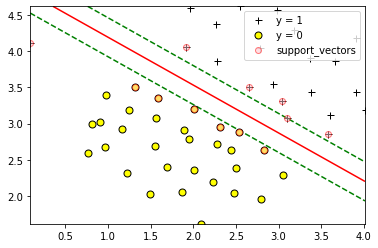

training acc: 98.04%


In [5]:
C = 1
model = svm.SVC(C=C, kernel='linear', max_iter=200, tol=1e-3)
model.fit(X, y.ravel())

visualizeBoundaryLinear(X, y, model)
acc = model.score(X, y.ravel()) * 100
print('training acc: %.2f%%' % acc)

## Part 3: Implementing Gaussian Kernel

In [6]:
def gaussianKernel(x1, x2, sigma):
    sim = 0

    # =========== code here ============
    sim = np.exp(-sum(np.square(x1 - x2)) / (2*sigma**2))
    # ==================================

    return sim

x1 = np.array([1,2,1])
x2 = np.array([0,4,-1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1=[1,2,1] and x2=[0,4,-1]: {}'.format(sim))

Gaussian Kernel between x1=[1,2,1] and x2=[0,4,-1]: 0.32465246735834974


## Part 4: Visualizing Dataset 2

X: (863, 2)
y: (863, 1)


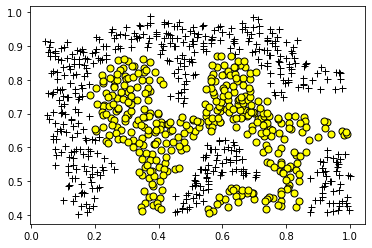

In [7]:
data = loadmat('ex6/ex6data2.mat')
X = data['X']
y = data['y']

print('X:', X.shape)
print('y:', y.shape)
plotData(X, y)
plt.show()

## Part 5: Training SVM with RBF Kernel (Dataset 2)

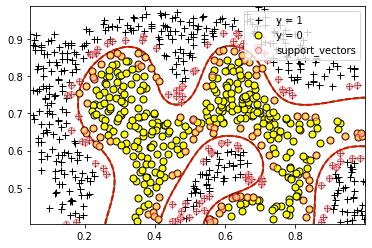

training acc: 98.96%


In [8]:
C = 1
sigma = 0.1
model = svm.SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2), max_iter=2000, tol=1e-3)
model.fit(X, y.ravel())

visualizeBoundaryLinear(X, y, model)
acc = model.score(X, y.ravel()) * 100
print('training acc: %.2f%%' % acc)

## Part 6: Visualizing Dataset 3

X: (211, 2)
y: (211, 1)


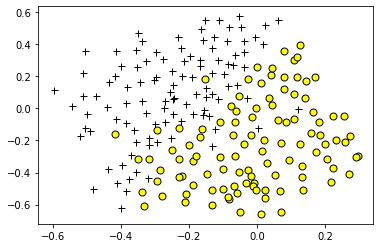

In [9]:
data = loadmat('ex6/ex6data3.mat')
X, Xval = data['X'], data['Xval']
y, yval = data['y'], data['yval']

print('X:', X.shape)
print('y:', y.shape)
plotData(X, y)
plt.show()

## Part 7: Training SVM with RBF Kernel (Dataset 3)

In [10]:
def dataset3Params(X, y, Xval, yval):
    C = 1
    sigma = 0.3
    steps = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    maxAcc = 0.0

    # =========== code here ============
    for Ci in steps:
        for sigmaj in steps:
            model = svm.SVC(C=Ci, kernel='rbf', gamma=1/(2*sigmaj**2), max_iter=2000, tol=1e-3)
            model.fit(X, y.ravel())
            acc = model.score(Xval, yval.ravel())
            if acc > maxAcc:
                maxAcc = acc
                C = Ci
                sigma = sigmaj
    # ==================================

    return C, sigma

C,sigma = dataset3Params(X, y, Xval, yval)
print('C = ', C, '  sigma = ', sigma)

C =  1.0   sigma =  0.1


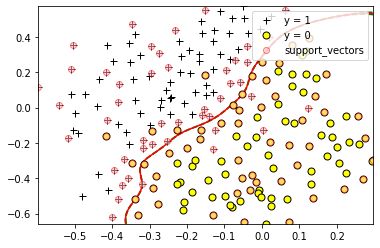

training acc: 94.79%


In [11]:
model = svm.SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2), max_iter=2000, tol=1e-3)
model.fit(X, y.ravel())

visualizeBoundaryLinear(X, y, model)
acc = model.score(X, y.ravel()) * 100
print('training acc: %.2f%%' % acc)

# ex6: Spam Classification with SVMs

## Part 1: Email Preprocessing

In [12]:
import utils

def getVocabList():
    vocabList = np.genfromtxt('ex6/vocab.txt', dtype=object)
    return list(vocabList[:,1].astype(str))

def processEmail(email_contents0, verbose=False):
    vocabList = getVocabList()
    word_indices = []

    # 转小写
    email_contents = email_contents0.lower()
    # 去除HTML
    email_contents = re.compile('<[^<>]+>').sub(' ', email_contents)
    # 替换URLs
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)
    # 替换邮件地址
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    # 替换美元标志
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    # 去除标点符号
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)
    # 去除空字符串
    email_contents = [word for word in email_contents if len(word) > 0]
    # 处理单词的时态、单复数等
    stemmer = utils.PorterStemmer()
    processed_email = []
    for word in email_contents:
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)
        if len(word) < 1:
            continue

    # =========== code here ============
    for word in processed_email:
        if word in vocabList:
            word_indices.append(vocabList.index(word))
    # ==================================
    
    if verbose:
        print('-------------')
        print('Original email:')
        print('-------------')
        print(email_contents0)

        print('-------------')
        print('Processed email:')
        print('-------------')
        print(' '.join(processed_email))

        print('\n\n-------------')
        print('word_indices:')
        print('-------------')
        print(word_indices)

    return word_indices


with open('ex6/emailSample1.txt') as fid:
    file_contents = fid.read()

word_indices = processEmail(file_contents, True)

-------------
Original email:
-------------
> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com


-------------
Processed email:
-------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than buck a month to a coupl of dollar you should checkout httpaddr or perhap amazon ec if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr


-------------
word_indices:
-------------
[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1061, 1698, 374, 1161, 476, 1892, 1509, 

## Part 2: Feature Extraction

In [13]:
def emailFeatures(word_indices):
    n = 1899
    x = np.zeros(n)

    # =========== code here ============
    for indice in word_indices:
        x[indice] = 1
    # ==================================
    
    return x

features = emailFeatures(word_indices)
print('Length of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

Length of feature vector: 1899
Number of non-zero entries: 44


## Part 3: Train Linear SVM for Spam Classification

In [14]:
data = loadmat('ex6/spamTrain.mat')
X = data['X']
y = data['y']

print('X:', X.shape)
print('y:', y.shape)

C = 0.1
model = svm.SVC(C=C, kernel='linear', max_iter=200, tol=1e-3)
model.fit(X, y)
acc = model.score(X, y.ravel()) * 100
print('training acc: %.2f%%' % acc)

X: (4000, 1899)
y: (4000, 1)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
training acc: 99.60%


## Part 4: Test Spam Classification

In [15]:
data = loadmat('ex6/spamTest.mat')
Xtest = data['Xtest']
ytest = data['ytest']

print('Xtest:', Xtest.shape)
print('ytest:', ytest.shape)

acc = model.score(Xtest, ytest.ravel()) * 100
print('test acc: %.2f%%' % acc)

Xtest: (1000, 1899)
ytest: (1000, 1)
test acc: 98.10%


## Part 5: Top Predictors of Spam

In [16]:
top_n = 25
w = model.coef_.ravel()
sorted_idx = np.argsort(w)
top_idx = sorted_idx[-top_n:][::-1]    # [::-1]倒叙
vocabList = getVocabList()

print('Top %d predictors of spam:' % top_n)
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for idx in top_idx:
    print('%-15s %-15s' % (vocabList[idx], w[idx]))

Top 25 predictors of spam:
word            weight         
----            ------
our             0.39133747647225864
click           0.37929253433531707
remov           0.3654692101855746
visit           0.3355575595662144
guarante        0.3275080439901974
basenumb        0.29266290191426225
dollar          0.25874981971264266
bodi            0.2334221669807212
ga              0.22245211182290936
below           0.2129331949931691
price           0.20982449956076943
most            0.20105215754707578
will            0.19986222680061178
al              0.19881384103857083
am              0.1897300034364122
hour            0.18646599851504383
nbsp            0.18380799218870425
credit          0.18154311773268386
want            0.1800809215351789
real            0.17557283101875532
contact         0.1739646115876601
sale            0.1729184861465637
pai             0.1728111130928605
lo              0.17222593044220907
recent          0.1720776208378904
